In [119]:
import numpy as np
import os
import torch
import torch.nn as nn
import math
import optuna
from optuna.trial import TrialState
from numpy import asarray
import pandas as pd
import torch.optim as optim
import random
from keras.datasets import mnist
import copy
from sklearn.metrics import mean_squared_error
from torchvision import datasets, models, transforms
from numpy import random
from scipy import ndimage
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as T
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
from astropy.visualization import simple_norm
import optuna
from optuna.trial import TrialState
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

**First doing all the GPU stuff

In [120]:
torch.cuda.empty_cache()
#checking if GPU is avaialble to be used
torch.cuda.is_available()
if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"  
device = torch.device(dev)  

**Next, making the proper input training image and label tensors (x_train is the training tensor and y_train are the labels corresponding to x_train)

In [121]:
x_data_old = np.load('x_data_gal.csv')
y_data_old = np.load('y_data_gal.csv')
y_data_old[:,0] = np.log(y_data_old[:,0])
y_data_old[:,1] = np.log(y_data_old[:,1])
min0 = np.min((y_data_old[:,0]))
max0 = np.max((y_data_old[:,0]))
min1 = np.min(y_data_old[:,1])
max1 = np.max((y_data_old[:,1]))
y_data_old[:,0] = ((y_data_old[:,0] - min0)/(max0 - min0))
y_data_old[:,1] = ((y_data_old[:,1]) - min1)/(max1 - min1)
x_data_old = torch.from_numpy(x_data_old)
y_data_old = torch.from_numpy(y_data_old)
print(x_data_old.shape)
print(y_data_old.shape)

torch.Size([2694, 1, 202, 202])
torch.Size([2694, 2])


In [122]:
y_data_old = y_data_old[:,1] #SETS WHETHER WE DO SFR OR SM

In [123]:
print(torch.min(y_data_old))
print(torch.max(y_data_old))

tensor(0.)
tensor(1.)


In [124]:
def remove_outliers(x_data,y_data,n): #removes %n outliers on both ends for SFR and mass
    y_sorted_sfr, indices = torch.sort(y_data)
    x_data_new = np.zeros(x_data.shape)
    y_data_new = np.zeros(y_data.shape)
    for i in range(len(x_data)):
        ind = indices[i]
        x_data_new[i] = x_data[ind]
        y_data_new[i] = y_data[ind]
    num = int((n/100*len(x_data))/2)
    x_data_new = x_data_new.astype('float32')
    y_data_new = y_data_new.astype('float32')
    x_data_new = x_data_new[num:-num]
    y_data_new = y_data_new[num:-num]
    x_data_new = torch.from_numpy(x_data_new)
    y_data_new = torch.from_numpy(y_data_new)
    return (x_data_new,y_data_new)

In [125]:
x_data,y_data = remove_outliers(x_data_old,y_data_old,25)

In [126]:
print(x_data.shape)
print(y_data.shape)

torch.Size([2022, 1, 202, 202])
torch.Size([2022])


**Now, splitting them into training, testing, and validation

In [127]:
#70:10:20 for training:valid:test (using only 2100 data points)
nb_train = int(0.7*len(x_data))
nb_valid = int(0.1*len(x_data))
nb_test = int(0.2*len(x_data))
nb_epoch = 100
batch_size = 38
#shuffling the data
random.seed(5)
idx = np.random.choice(len(x_data), size=len(x_data), replace=False)
x_data = x_data[idx]
y_data = y_data[idx]

# indices for where to slice the arrays
ind_valid_start = ind_train_end = nb_train
ind_valid_end = ind_test_start = nb_train + nb_valid
ind_test_end = nb_train + nb_valid + nb_test

# slice the image arrays
x_train = x_data[:ind_train_end, :, :]
x_valid = x_data[ind_valid_start: ind_valid_end, :, :]
x_test = x_data[ind_test_start: ind_test_end, :, :]

# slice the label arrays
y_train = y_data[:ind_train_end]
y_valid = y_data[ind_valid_start: ind_valid_end]
y_test = y_data[ind_test_start: ind_test_end]

In [128]:
x_train = x_train.to(device)
x_test = x_test.to(device)
x_valid = x_valid.to(device)
y_valid = y_valid.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

In [129]:
dataset_train = TensorDataset(x_train, y_train)
dataset_valid = TensorDataset(x_valid, y_valid)
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_valid = DataLoader(dataset_valid, batch_size=len(y_valid), shuffle=True)

In [130]:
print(x_train.shape)
print(y_train.shape)
print(x_valid.shape)
print(y_valid.shape)

torch.Size([1415, 1, 202, 202])
torch.Size([1415])
torch.Size([202, 1, 202, 202])
torch.Size([202])


In [131]:
print(y_test.shape)

torch.Size([404])


**Creating the model

In [132]:
class galmodel(nn.Module):
    #def __init__(self,trial):
    def __init__(self):
        super().__init__()
        #n_outp1 = trial.suggest_int("n_outp1", 1, 40)  
        #n_outp2 = trial.suggest_int("n_outp2", 1, 40)  
        #nmp1 = trial.suggest_int("nmp1", 1, 40)
        #nmp2 = trial.suggest_int("nmp2", 1, 40)
        #dropout1 = trial.suggest_float("dropout1", 0, 1) 
        #dropout2 = trial.suggest_float("dropout2", 0, 1)  

        n_outp1 = 2
        n_outp2 = 8
        nmp1 = 15
        nmp2 = 14
        dropout1 = 0.7
        dropout2 = 0.3

        
        self.conv1 = nn.Conv2d(1, n_outp1, kernel_size=(5,5), stride=(1,1), padding=2)
        self.act1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(n_outp1)
        self.mp1 = nn.AdaptiveMaxPool2d(nmp1)
        self.drop1 = nn.Dropout(dropout1)
        
        self.conv2 = nn.Conv2d(n_outp1, n_outp2, kernel_size=(3,3), stride=(1,1), padding=2)
        self.act2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(n_outp2)
        self.mp2 = nn.AdaptiveMaxPool2d(nmp2)
        self.drop2 = nn.Dropout(dropout2)

        n_outp3 = 21
        n_outp4 = 35
        nmp3 = 2
        nmp4 = 5
        dropout3 = 0.5
        dropout4 = 0.1
        
        self.conv3 = nn.Conv2d(n_outp2, n_outp3, kernel_size=(3,3), stride=(1,1), padding=1)
        self.act3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(n_outp3)
        self.mp3 = nn.AdaptiveMaxPool2d(nmp3)
        self.drop3 = nn.Dropout(dropout3)
        
        self.conv4 = nn.Conv2d(n_outp3, n_outp4, kernel_size=(3,3), stride=(1,1), padding=1)
        self.act4 = nn.ReLU()
        self.bn4 = nn.BatchNorm2d(n_outp4)
        self.mp4 = nn.AdaptiveMaxPool2d(nmp4)
        self.drop4 = nn.Dropout(dropout4)
        
        self.f5 = nn.Flatten(start_dim=1,end_dim=-1)
        self.ln5_1 = nn.Linear(n_outp4*nmp4*nmp4,10)
        self.r5_1 = nn.ReLU()
        self.ln5_2 = nn.Linear(10,27)
        self.r5_2 = nn.ReLU()
        self.ln5_3 = nn.Linear(27,2)
            
    def forward(self,x):
        x = self.conv1(x)
        x = self.act1(x)
        x = self.bn1(x)
        x = self.mp1(x)
        x = self.drop1(x)
        
        x = self.conv2(x)
        x = self.act2(x)
        x = self.bn2(x)
        x = self.mp2(x) 
        x = self.drop2(x) 
        
        x = self.conv3(x)
        x = self.act3(x)
        x = self.bn3(x)
        x = self.mp3(x) 
        x = self.drop3(x) 
        
        x = self.conv4(x)
        x = self.act4(x)
        x = self.bn4(x)
        x = self.mp4(x) 
        x = self.drop4(x)
        
        x = self.f5(x)
        x = self.ln5_1(x)
        x = self.r5_1(x)
        x = self.ln5_2(x)
        x = self.r5_2(x)
        x = self.ln5_3(x)
        return x

In [133]:
def loss_function(y_pred_batch,y_true_batch):
    loss_fn = nn.GaussianNLLLoss()
    #loss_fn = nn.MSELoss()
    var = torch.square(y_pred_batch[:,1])
    loss = loss_fn(y_pred_batch[:,0],y_true_batch,var)
    #loss = loss_fn(y_pred_batch,y_true_batch)
    return loss

mse: -0.11791905015707016, best: inf
mse: -0.9708440899848938, best: -0.11791905015707016
mse: 3.1199984550476074, best: -0.9708440899848938
mse: 1420.40380859375, best: -0.9708440899848938
mse: 119.83800506591797, best: -0.9708440899848938
mse: 0.6334683299064636, best: -0.9708440899848938
mse: -0.5615960359573364, best: -0.9708440899848938
mse: 16.065956115722656, best: -0.9708440899848938
mse: 53.700538635253906, best: -0.9708440899848938
mse: 481.0085754394531, best: -0.9708440899848938
mse: 562.1842651367188, best: -0.9708440899848938
mse: 1.3587987422943115, best: -0.9708440899848938
mse: -1.3324346542358398, best: -0.9708440899848938
mse: -0.7127156853675842, best: -1.3324346542358398
mse: -0.39882805943489075, best: -1.3324346542358398
mse: 175.06959533691406, best: -1.3324346542358398
mse: 52.80327606201172, best: -1.3324346542358398
mse: 76.93182373046875, best: -1.3324346542358398
mse: 43.39499282836914, best: -1.3324346542358398
mse: 6.9537787437438965, best: -1.33243465423

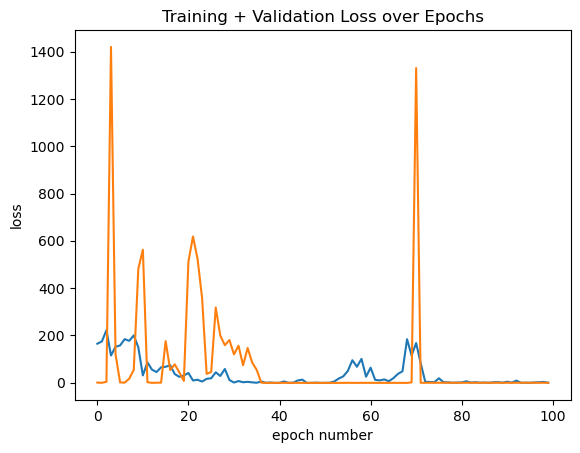

In [134]:
model = galmodel()
if torch.cuda.is_available():
    model.cuda()
learning_rate = 0.0002
wd = 0.0003
optimizer = optim.Adam(model.parameters(), lr=learning_rate,weight_decay=wd)
av_loss_ar = []
# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
valid_history = np.zeros(nb_epoch)
train_history = np.zeros(nb_epoch)
last_loss = 0
for i in range(nb_epoch):
    model.train()
    ep_train_loss = []
    for step, (x_batch, y_batch) in enumerate(dataloader_train): 
        print("Current Epoch: " + str(i) + ", Last Loss: " + str(last_loss),end="\r")
        y_pred_batch = model(x_batch)
        y_pred_batch = torch.squeeze(y_pred_batch)
        loss = loss_function(y_pred_batch,y_batch) #sum of the mean squared error / nb_batch
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        ep_train_loss.append(loss)
    train_history[i] = (sum(ep_train_loss)/(nb_train/batch_size))
    #now, once an epoch is done:
    model.eval()
    y_pred = model(x_valid)
    y_pred = torch.squeeze(y_pred)
    mse = loss_function(y_pred, y_valid)
    mse = float(mse)
    last_loss = mse
    valid_history[i] = mse
    print("mse: " + str(mse) + ", best: " + str(best_mse))
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict()) 
  #  if(mse < total_best_mse):
   #     torch.save(model.state_dict(), 'best-model-parameters.pt')
    #    total_best_mse
plt.plot(train_history)
plt.plot(valid_history) 
plt.ylabel("loss")
plt.xlabel("epoch number")
plt.title("Training + Validation Loss over Epochs")
plt.show()

**Training the model

In [135]:
model.load_state_dict(best_weights)
model.eval()
loss_fn = nn.GaussianNLLLoss()
y_pred = model(x_test)

In [136]:
y_pred_np = y_pred.detach().cpu().numpy()
y_test_np = y_test.detach().cpu().numpy()

<ErrorbarContainer object of 3 artists>

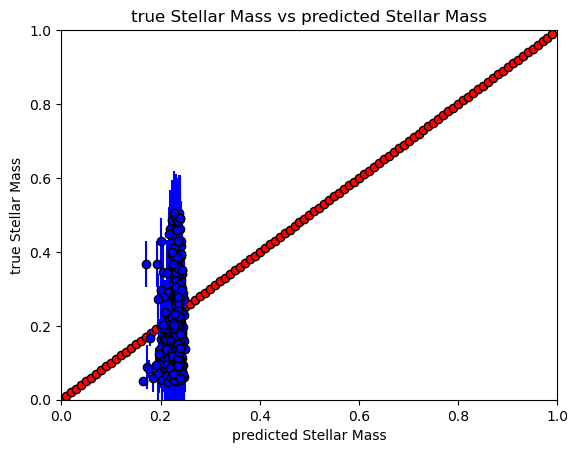

In [137]:
x = np.arange(0,1,0.01)
plt.xlim((0,1))
plt.ylim((0,1))
plt.scatter(x,x,c="red",ec="black")
plt.xlabel("predicted Stellar Mass")
plt.ylabel("true Stellar Mass")
plt.title("true Stellar Mass vs predicted Stellar Mass")
#print(y_pred_np[:,1])
plt.errorbar(y_pred_np[:,0], y_test_np,markerfacecolor='blue',markeredgecolor='black',yerr = np.abs(y_pred_np[:,1]),color="blue",fmt ='o')

In [225]:
def objective(trial):
    model = galmodel(trial)
    if torch.cuda.is_available():
        model.cuda()
    learning_rate = trial.suggest_float("lr", 0, 0.9) 
    wd = 0.0003 
    loss_fn = nn.MSELoss(reduction="mean") #mean_squared_error from before!
    optimizer = optim.Adam(model.parameters(), lr=learning_rate,weight_decay=wd)
    av_loss_ar = []
    # Hold the best model
    best_mse = np.inf   # init to infinity
    best_weights = None
    valid_history = np.zeros(nb_epoch)
    train_history = np.zeros(nb_epoch)
    last_loss = 0
    for i in range(nb_epoch):
        model.train()
        ep_train_loss = []
        for step, (x_batch, y_batch) in enumerate(dataloader_train): 
            print("Current Epoch: " + str(i) + ", Last Loss: " + str(last_loss),end="\r")
            y_pred_batch = model(x_batch)
            loss = loss_function(y_pred_batch,y_batch) #sum of the mean squared error / nb_batch
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            ep_train_loss.append(loss)
        train_history[i] = (sum(ep_train_loss)/(nb_train/batch_size))
        #now, once an epoch is done:
        model.eval()
        y_pred = model(x_valid)
        mse = loss_function(y_pred, y_valid)
        mse = float(mse)
        last_loss = mse
        valid_history[i] = mse
        if mse < best_mse:
            best_mse = mse
            best_weights = copy.deepcopy(model.state_dict()) 
        trial.report(best_mse, nb_epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    plt.plot(train_history)
    plt.plot(valid_history) 
    plt.ylabel("loss")
    plt.xlabel("epoch number")
    plt.title("Training + Validation Loss over Epochs")
    plt.show()
    return best_mse

In [23]:
if __name__ == "__main__":
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=75, timeout=6000)

    pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
    complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print("  Number of pruned trials: ", len(pruned_trials))
    print("  Number of complete trials: ", len(complete_trials))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))


[I 2024-02-09 18:12:01,100] A new study created in memory with name: no-name-11255f9e-f912-4f9f-b384-d8e68934abee


NameError: name 'objective' is not defined